<a href="https://colab.research.google.com/github/jeroenboeye/agent-course/blob/main/Agent_course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Agentic AI 101

Import dependencies

In [ ]:
pip install --quiet langchain-core==1.2.7 langchain-experimental==0.4.1 pydantic==2.12.3 wikipedia==1.4.0 langgraph==1.0.5 langchain-openai==1.1.7 requests==2.32.5 langgraph_swarm==0.1.0

In [ ]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

# REPL = Read-Eval-Print Loop
repl = PythonREPL()

@tool
def python_tool(
    code: Annotated[str, "The python code to execute to generate a chart."],
):
    """Use this tool to execute python code. Make sure the python code is valid.
    To see the output of a value, you should print it out with `print(...)`.
    This is visible to the user.
    If you create a chart it should be displayed using `plt.show()`."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"""Successfully executed the Python tool.\n\nPython code executed:\n```python\n{code}\n```\n\nCode output:\n```\n{result}\n```"""



In [ ]:
code = f"""
import numpy as np

arr = np.arange(0, 4)
print(arr)
print(3 * arr)
"""

print(python_tool.invoke({"code": code}))

In [ ]:
code = f"""
import matplotlib.pyplot as plt
import numpy as np

arr = np.arange(0, 4)
plt.plot(arr)
plt.show()
"""

print(python_tool.invoke({"code": code}))

In [ ]:
import requests

@tool
def read_csv_from_url_tool(
    url: Annotated[str, "The public URL of the CSV file to read"],
):
    """
    Fetches the text content of a CSV file from any public URL.
    """
    try:
        response = requests.get(url)
        # Checks for HTTP errors (404, 500, etc.)
        response.raise_for_status()
        return response.text

    except Exception as e:
        return f"Failed to fetch CSV from {url}: {repr(e)}"
file_content = read_csv_from_url_tool.invoke({"url": "https://raw.githubusercontent.com/plotly/datasets/master/stockdata.csv"})
print(file_content[:238])

In [ ]:

import os
@tool
def file_io_tool(
    spec: Annotated[str, "Format: `read:<path>` or `write:<path>::<content>`"],
):
    """
    Reads or writes files on disk.
    """
    try:
        if spec.startswith("read:"):
            path = spec.replace("read:", "")
            with open(path, "r") as f:
                return f.read()

        if spec.startswith("write:"):
            clean_spec = spec[6:] # Removes "write:"
            if "::" not in clean_spec:
                 return "Invalid format. Missing '::' separator."

            path, content = clean_spec.split("::", 1)

            os.makedirs(os.path.dirname(path), exist_ok=True)

            with open(path, "w") as f:
                f.write(content)
            return f"Successfully wrote to {path}"

        return "Invalid format. Use `read:<path>` or `write:<path>::<content>`"
    except Exception as e:
        return f"File op failed: {repr(e)}"

print(file_io_tool.invoke({"spec": f"write:sample_data/stockdata.csv::{file_content}"}))


In [ ]:
@tool
def inspect_filesystem_tool(
    path: Annotated[str, "The directory path to inspect. Defaults to current directory '.'"] = ".",
):
    """
    Lists the contents of a directory.
    Useful for finding files when you don't know the exact path.
    """
    try:
        # specific check if the LLM guesses a file path instead of a directory
        if os.path.isfile(path):
            return f"'{path}' is a specific file, not a directory. Parent dir contains: {os.listdir(os.path.dirname(path) or '.')}"

        if not os.path.exists(path):
            return f"Path '{path}' does not exist."

        items = os.listdir(path)

        # separate items into files and directories for clarity
        files = []
        dirs = []
        for item in items:
            full_path = os.path.join(path, item)
            if os.path.isdir(full_path):
                dirs.append(item + "/")
            else:
                files.append(item)

        output = f"Contents of '{path}':\n"
        if dirs:
            output += "Directories:\n" + "\n".join(f"  {d}" for d in dirs) + "\n"
        if files:
            output += "Files:\n" + "\n".join(f"  {f}" for f in files)

        if not files and not dirs:
            return f"Directory '{path}' is empty."

        return output

    except Exception as e:
        return f"Error inspecting path: {repr(e)}"
print(inspect_filesystem_tool.invoke({"path": "sample_data"}))

In [ ]:
import wikipedia
@tool
def wikipedia_tool(
    query: Annotated[str, "The Wikipedia search to execute to find key summary information."],
):
    """Use this tool to search Wikipedia for factual information."""
    try:
        results = wikipedia.search(query)

        if not results:
            return "No results found on Wikipedia."

        summary = wikipedia.summary(results[0], sentences=8, auto_suggest=False, redirect=True)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\nWikipedia summary: {summary}"

print(wikipedia_tool.invoke({"query": "Marie Curie"}))

In [ ]:
for tool in [wikipedia_tool, python_tool, file_io_tool, inspect_filesystem_tool, read_csv_from_url_tool]:
    print(f"The docstring/description for {tool.name}:\n> {tool.description}\n")

# Our (very simple) flow so far

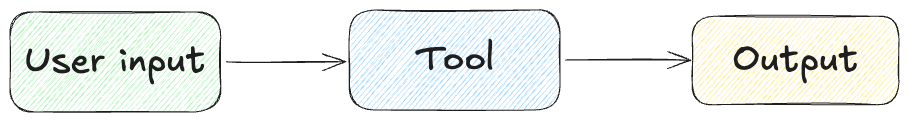

## Adding an LLM to the mix

In [ ]:
from langchain_openai import ChatOpenAI
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")


In [ ]:
llm = ChatOpenAI(model="gpt-5-nano")
response = llm.invoke("Hello, world!")
print(response.text)

## Binding the steps together with Langgraph

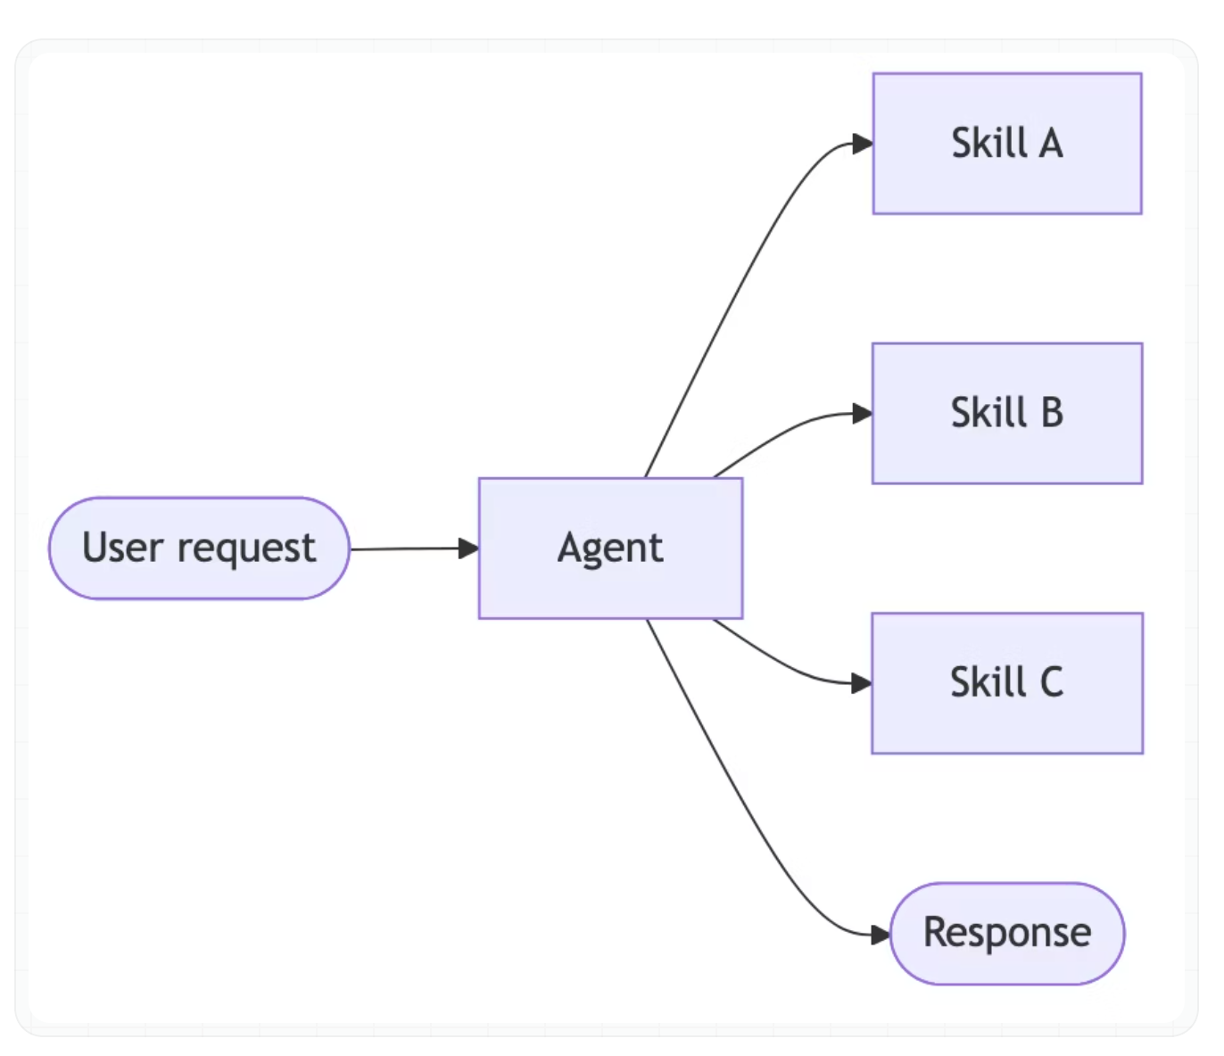

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tools = [inspect_filesystem_tool, python_tool, file_io_tool]

# Tell the LLM which tools it has access to
llm_with_tools = llm.bind_tools(tools)

# Pass on the state to the llm
def llm_node(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Create the llm and tools nodes
graph_builder.add_node("llm", llm_node)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Add the edges
graph_builder.add_edge(START, "llm")
graph_builder.add_conditional_edges("llm", tools_condition, ["tools", END])
graph_builder.add_edge("tools", "llm")

graph = graph_builder.compile()
graph

In [ ]:
from langchain_core.messages.tool import ToolMessage
from langchain_core.messages.ai import AIMessage

for chunk in graph.stream(
    {"messages": [{"role": "user", "content": "Find the stock data file and plot the data for IBM"}]}
):
  for source, output in chunk.items():
    print("-"*150)
    message = output["messages"][0]
    if isinstance(message, AIMessage):
      print(f"{source}, output: {message.content}, tool calls: {message.tool_calls}")
    elif isinstance(message, ToolMessage):
      if message.name == "file_io_tool":
        print(f"{source} {message.name}: {message.content[:234]}...")
      else:
        print(f"{source} {message.name}: {message.content}")
    # print(message)


## Our new flow

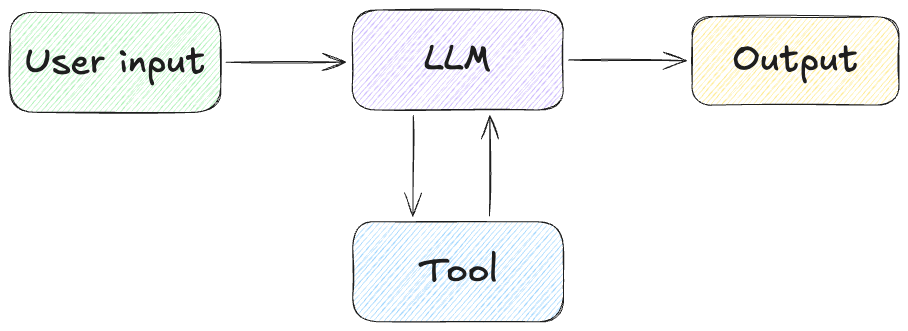

## Achieving the same result with high-level code

In [ ]:

from langgraph.prebuilt import create_react_agent
prompt = """
You are an assistant for fetching and plotting stock data. You have access to three tools:
- A filesystem inspection tool to find files locally
- A file io tool to read and write files
- A Python tool for executing Python code, can be used to create visualizations
"""
# Create an agent using the create_react_agent function
agent = create_react_agent(
    llm,
    tools=tools,
    name="stock_assistant",
    prompt=prompt,
)
agent

In [ ]:
for chunk in graph.stream(
    {"messages": [{"role": "user", "content": "Find the stock data file and plot the data for IBM"}]}
):
  for source, output in chunk.items():
    print("-"*150)
    message = output["messages"][0]
    if isinstance(message, AIMessage):
      print(f"{source}, output: {message.content}, tool calls: {message.tool_calls}")
    elif isinstance(message, ToolMessage):
      if message.name == "file_tool":
        print(f"{source} {message.name}: {message.content[:234]}...")
      else:
        print(f"{source} {message.name}: {message.content}")
    # print(message)


## Creating a multi-agent system using handoffs

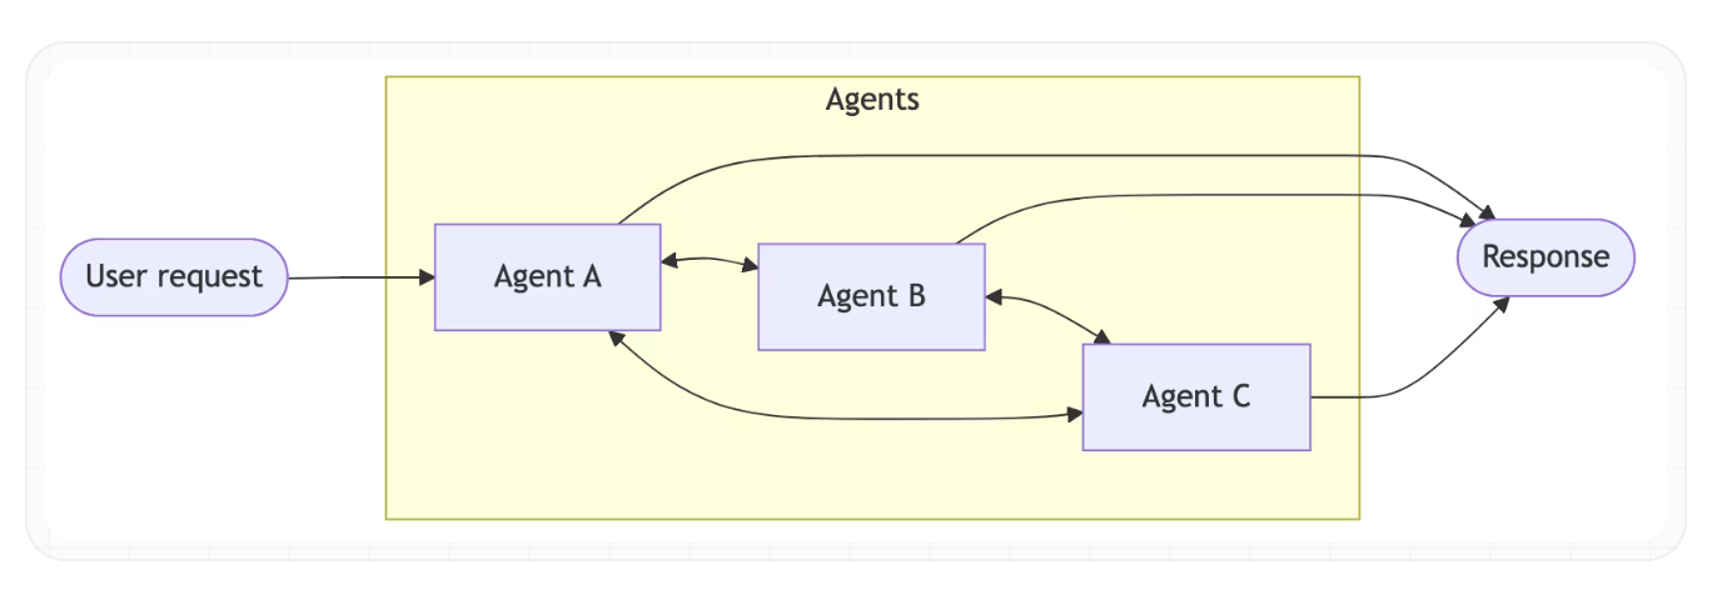

In [ ]:
from langgraph_swarm import create_handoff_tool
from langgraph.prebuilt import create_react_agent

# Handoff tools
transfer_to_data_engineer = create_handoff_tool(
    agent_name="data_engineer",
    description="Transfer user to the data engineer, who can retrieve relevant files and inspect the file system.",
)

transfer_to_data_scientist = create_handoff_tool(
    agent_name="data_scientist",
    description="Transfer user to the data scientist assistant, who can create visualizations of provided data.",
)

# Agents

engineer_prompt = """You are a Data Engineer.
Your responsibilities:
1. Use the filesystem tools to locate specific data files requested by the user.
2. Once you have located and verified the data file exists, transfer control to the Data Scientist to perform the analysis.
Do NOT attempt to plot data yourself."""
data_engineer_agent = create_react_agent(
    llm,
    tools=[inspect_filesystem_tool, file_io_tool, transfer_to_data_scientist],
    prompt=engineer_prompt,
    name="data_engineer"
)

scientist_prompt = """You are a Data Scientist.
Your responsibilities:
1. Receive file paths or data content from the Data Engineer.
2. Use the Python tool to generate visualizations and save them to a png file.
If you do not know where the file is, transfer control back to the Data Engineer to find it."""

data_scientist_agent = create_react_agent(
    llm,
    [python_tool, transfer_to_data_engineer],
    prompt=scientist_prompt,
    name="data_scientist"
)


In [ ]:
from langgraph_swarm import create_swarm
from langgraph.checkpoint.memory import InMemorySaver

config = {"configurable": {"thread_id": "1", "user_id": "1"}}
checkpointer = InMemorySaver()

# Create the swarm multi-agent graph and compile it
swarm = create_swarm(
    agents=[data_engineer_agent, data_scientist_agent],
    default_active_agent="data_engineer"
).compile(checkpointer=checkpointer)
swarm

In [ ]:
for chunk in swarm.stream(
    {"messages": [{"role": "user", "content": "Find and plot microsoft and apple stock data."}]}, config
):
    print(chunk)

In [ ]:

print("=== Starting Swarm Execution Replay ===\n")

for chunk in swarm.stream(
    {"messages": [{"role": "user", "content": "Find and plot microsoft and apple stock data."}]}, config
):
    for source, output in chunk.items():
        print(f"\n--- Active Agent: {source.upper()} ---")

        # Depending on the format, output['messages'] might be a list
        messages = output.get("messages", [])

        for message in messages:
            print("-" * 80)

            # 1. Handle AI Messages (Reasoning & Tool Calls)
            if isinstance(message, AIMessage):
                if message.content:
                    print(f"🤖 {source} (Thought): {message.content}")

                if message.tool_calls:
                    for tc in message.tool_calls:
                        print(f"🛠️ {source} calls tool: {tc['name']}")
                        print(f"   Args: {tc['args']}")

                        # SPECIAL HANDLING: If python tool, execute the code to show the user the plot
                        if tc['name'] == 'python_tool' and 'code' in tc['args']:
                            print("\n   [Visualizer]: Detected plotting code. Executing now...")
                            try:
                                exec(tc['args']['code'])
                                print("   [Visualizer]: Plot rendered successfully.")
                            except Exception as e:
                                print(f"   [Visualizer]: Could not render plot: {e}")

            # 2. Handle Tool Messages (Outputs)
            elif isinstance(message, ToolMessage):
                # Truncate long outputs for readability
                content_preview = message.content[:200] + "..." if len(message.content) > 200 else message.content
                print(f"📄 Tool Output ({message.name}): {content_preview}")